In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

[*********************100%***********************]  1 of 1 completed


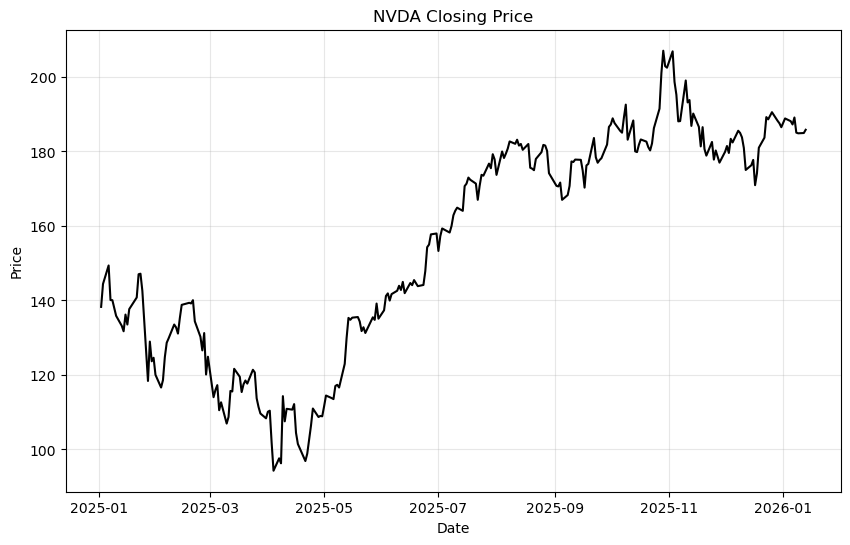

In [2]:
ticker = "NVDA"
df = yf.download(ticker, start='2025-01-01', auto_adjust=True)

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], color='black')
plt.ylabel('Price')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.title(f'{ticker} Closing Price')
plt.show()

In [3]:
# Moving Average Convergence Divergence (MACD)
# The MACD shows relationship between two EMAs, e.g., MACD = EMA12 - EMA26, and the signal line is defined as an EMA of the MACD line itself. 

def calculate_macd(df: pd.DataFrame, fast_period: int = 12, slow_period: int = 26, signal_period: int = 9, column: str = 'Close') -> pd.DataFrame:
    """
    Parameters:
    - df: DataFrame with price data.
    - fast_period, slow_period, signal_period: defaults 12, 26, 9.
    - column: yf data column to use (default 'Close').
    
    Returns:
    - DataFrame with 'macd', 'signal', 'histogram'.

    Interpretation: MACD > Signal = bullish; divergences warn of reversals. Great for momentum in trending markets.
    """
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not in DataFrame.")
    if len(df) < max(fast_period, slow_period, signal_period):
        raise ValueError("DataFrame too small for periods.")
    
    ema_fast = df[column].ewm(span=fast_period, adjust=False).mean() # when adjust=False, the exponentially weighted function is calculated recursively
    ema_slow = df[column].ewm(span=slow_period, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    histogram = macd - signal
    return pd.DataFrame({'macd': macd.values.flatten(), 'signal': signal.values.flatten(), 'histogram': histogram.values.flatten()}, index=df.index)


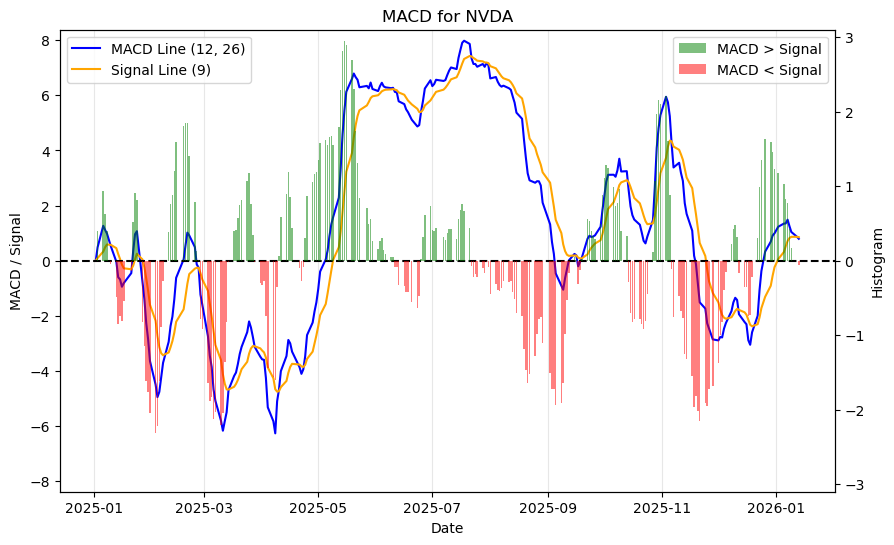

In [4]:
# Example (MACD)

macd_fast_period = 12
macd_slow_period = 26
macd_signal_period = 9
MACD = calculate_macd(df, macd_fast_period, macd_slow_period, macd_signal_period)

# Set apart positive and negative histogram values for coloring
pos_hist = MACD['histogram'] >= 0
neg_hist = MACD['histogram'] < 0

# Plot MACD and Signal over the left axis
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(df.index, MACD['macd'], label=f'MACD Line ({macd_fast_period}, {macd_slow_period})', color='blue', linewidth=1.5)
ax1.plot(df.index, MACD['signal'], label=f'Signal Line ({macd_signal_period})', color='orange', linewidth=1.5)
ax1.set_ylabel('MACD / Signal')
ax1.set_xlabel('Date')
ax1.legend(loc='upper left')
ax1.grid(True, axis='x', alpha=0.3)

# Plot Histogram over the right axis
ax2 = ax1.twinx()  # create a second y-axis sharing the same x-axis
ax2.bar(df.index[pos_hist], MACD['histogram'][pos_hist], color='green', alpha=0.5, label='MACD > Signal')
ax2.bar(df.index[neg_hist], MACD['histogram'][neg_hist], color='red', alpha=0.5, label='MACD < Signal')
ax2.set_ylabel('Histogram')
ax2.legend(loc='upper right')

# To make y=0 overlap, we center 0 on both axes by setting symmetric limits.
max_line_val = max(MACD['macd'].abs().max(), MACD['signal'].abs().max()) # calculate max extent for left axis
ax1.set_ylim(-max_line_val * 1.05, max_line_val * 1.05) # add a small margin (e.g., 10%)
max_hist_val = MACD['histogram'].abs().max() # calculate max extent for right axis
ax2.set_ylim(-max_hist_val * 1.05, max_hist_val * 1.05)

# Draw the zero line 
ax1.axhline(0, color='black', linestyle='--')

plt.title(f'MACD for {ticker}')
plt.show()

In [5]:
# Relative Strength Index (RSI)
# RSI measures speed and change of price movements: RSI = 100 - (100 / (1 + RS)), where RS = Average Gain / Average Loss.

def calculate_rsi(df: pd.DataFrame, period: int = 14, column: str = 'Close') -> pd.Series:
    """
    Parameters:
    - df: DataFrame with price data.
    - period: window size (default 14).
    - column: yf data column to use (default 'Close').
    
    Returns:
    - Series with RSI values.

    Interpretation: >70 overbought; <30 oversold. Divergences signal reversals.
    """
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not in DataFrame.")
    if len(df) < period + 1:
        raise ValueError(f"DataFrame must have at least {period + 1} rows.")
    
    delta = df[column].diff() # price changes
    gain = delta.where(delta > 0, 0).rolling(window=period).mean() # DataFrame.where(cond, other) means if "cond" is True the element there is used; otherwise the corresponding element from "other" is used in that place
    loss = -delta.where(delta < 0, 0).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


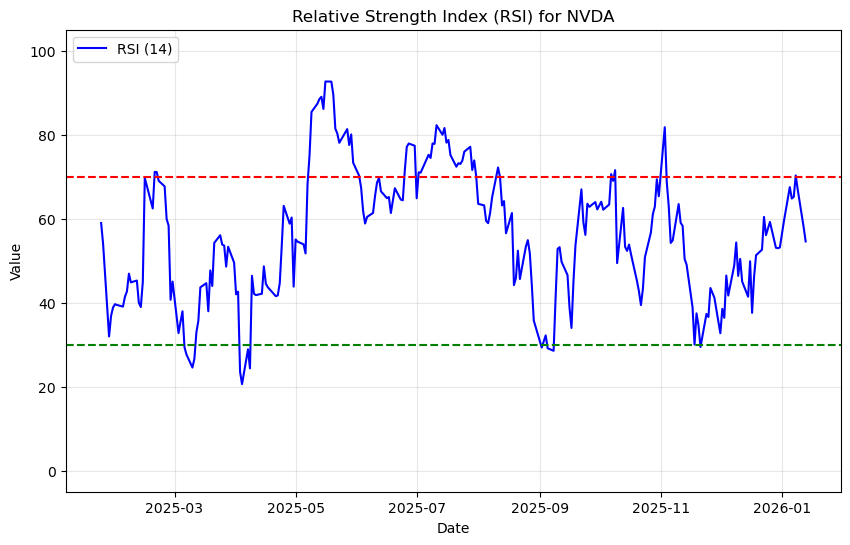

In [6]:
# Example (RSI)

rsi_period = 14
RSI = calculate_rsi(df, rsi_period)

plt.figure(figsize=(10, 6))
plt.plot(df.index, RSI, label=f'RSI ({rsi_period})', color='blue', linewidth=1.5)
plt.ylim(-5, 105)
plt.ylabel('Value')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')

plt.title(f'Relative Strength Index (RSI) for {ticker}')
plt.show()

In [7]:
# Stochastic Oscillator
# STOCH compares closing price to price range: 
# %K = 100 x (Current Close - Low(14)) / (High(14) - Low(14)), where High(14) and Low(14) are the highest High and lowest Low in the last 14 days
# %D = 3-day SMA of %K

def calculate_stochastic(df: pd.DataFrame, k_period: int = 14, d_period: int = 3) -> pd.DataFrame:
    """
    Parameters:
    - df: DataFrame with 'High', 'Low', 'Close'.
    - k_period: for %K (default 14).
    - d_period: for %D (default 3).
    
    Returns:
    - DataFrame with 'percent_k', 'percent_d'.
    
    Interpretation: >80 overbought; <20 oversold. %K cross %D signals trades.
    """
    required_cols = ['High', 'Low', 'Close']
    if not all(col in df.columns for col in required_cols):
        raise ValueError("DataFrame missing required columns: High, Low, Close.")
    if len(df) < k_period:
        raise ValueError(f"DataFrame must have at least {k_period} rows.")
    
    low_min = df['Low'].rolling(window=k_period).min()
    high_max = df['High'].rolling(window=k_period).max()
    percent_k = 100 * (df['Close'] - low_min) / (high_max - low_min)
    percent_d = percent_k.rolling(window=d_period).mean()
    return pd.DataFrame({'percent_k': percent_k.values.flatten(), 'percent_d': percent_d.values.flatten()}, index=df.index)


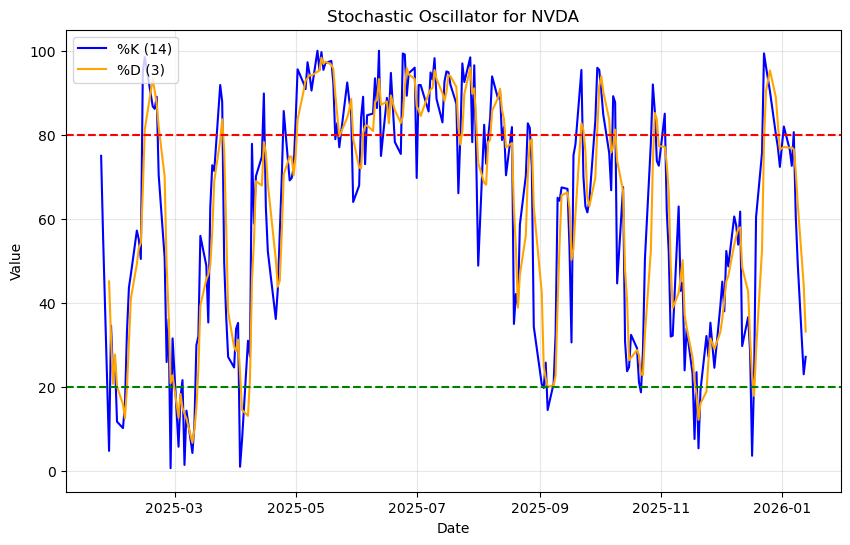

In [8]:
# Example (Stochastic Oscillator)

stoch_k_period = 14
stoch_d_period = 3
STOCH = calculate_stochastic(df, stoch_k_period, stoch_d_period)

plt.figure(figsize=(10, 6))
plt.plot(df.index, STOCH['percent_k'], label=f'%K ({stoch_k_period})', color='blue', linewidth=1.5)
plt.plot(df.index, STOCH['percent_d'], label=f'%D ({stoch_d_period})', color='orange', linewidth=1.5)
plt.ylim(-5, 105)
plt.ylabel('Value')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.axhline(80, color='red', linestyle='--', label='Overbought (80)')
plt.axhline(20, color='green', linestyle='--', label='Oversold (20)')

plt.title(f'Stochastic Oscillator for {ticker}')
plt.show()

In [9]:
# Commodity Channel Index (CCI)
# CCI measures an instrument's variation away from its statistical mean and identifies cyclical trends.
# CCI = (Typical Price - SMA of TP) / (0.015 x MAD), where 
    # - Typical Price (TP) = (High + Low + Close) / 3;
    # - Mean Absolute Deviation (MAD) = Average of |TP - SMA of TP|. 

def calculate_cci(df: pd.DataFrame, period: int = 20) -> pd.Series:
    """    
    Parameters:
    - df: DataFrame with 'High', 'Low', 'Close'.
    - period: window size (default 20).
    
    Returns:
    - Series with CCI values.
    
    Interpretation: >100 overbought; <-100 oversold. Use in ranging markets.
    
    """
    required_cols = ['High', 'Low', 'Close']
    if not all(col in df.columns for col in required_cols):
        raise ValueError("DataFrame missing required columns.")
    if len(df) < period:
        raise ValueError(f"DataFrame must have at least {period} rows.")
    
    tp = (df['High'] + df['Low'] + df['Close']) / 3
    sma_tp = tp.rolling(window=period).mean()
    mad = abs(tp - sma_tp).rolling(window=period).mean()
    cci = (tp - sma_tp) / (0.015 * mad)
    return cci


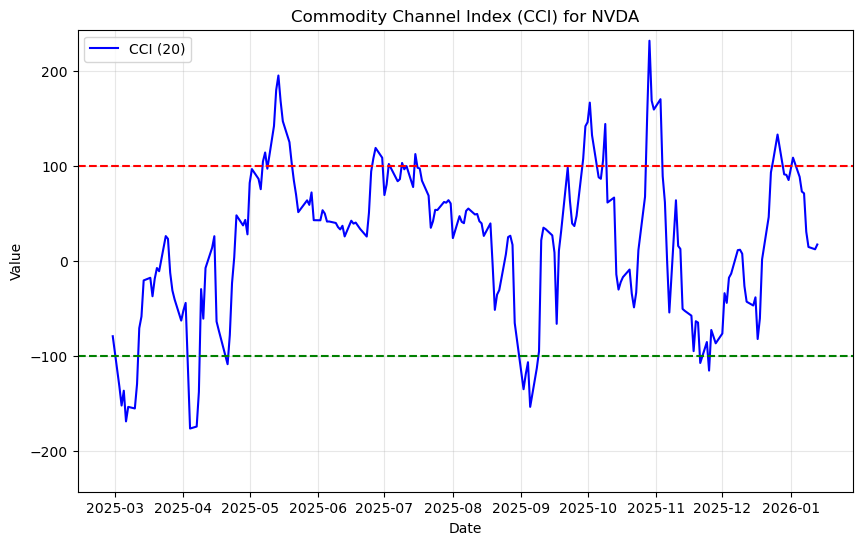

In [10]:
# Example (CCI)

cci_period = 20
CCI = calculate_cci(df, cci_period)

plt.figure(figsize=(10, 6))
plt.plot(df.index, CCI, label=f'CCI ({cci_period})', color='blue', linewidth=1.5)
max_cci_val = np.abs(CCI.dropna().values).max()
plt.ylim(-max_cci_val * 1.05, max_cci_val * 1.05)
plt.ylabel('Value')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.axhline(100, color='red', linestyle='--', label='Overbought (100)')
plt.axhline(-100, color='green', linestyle='--', label='Oversold (-100)')

plt.title(f'Commodity Channel Index (CCI) for {ticker}')
plt.show()

In [11]:
# Williams %R 
# %R = (Highest High - Current Close) / (Highest High - Lowest Low) x -100.

def calculate_williams_r(df: pd.DataFrame, period: int = 14) -> pd.Series:
    """    
    Parameters:
    - df: DataFrame with 'High', 'Low', 'Close'.
    - period: window size (default 14).
    
    Returns:
    - Series with %R values (-100 to 0).
    
    Interpretation: >-20 overbought; <-80 oversold.
    """
    required_cols = ['High', 'Low', 'Close']
    if not all(col in df.columns for col in required_cols):
        raise ValueError("DataFrame missing required columns.")
    if len(df) < period:
        raise ValueError(f"DataFrame must have at least {period} rows.")
    
    high_max = df['High'].rolling(window=period).max()
    low_min = df['Low'].rolling(window=period).min()
    will_r = (high_max - df['Close']) / (high_max - low_min) * -100
    return will_r


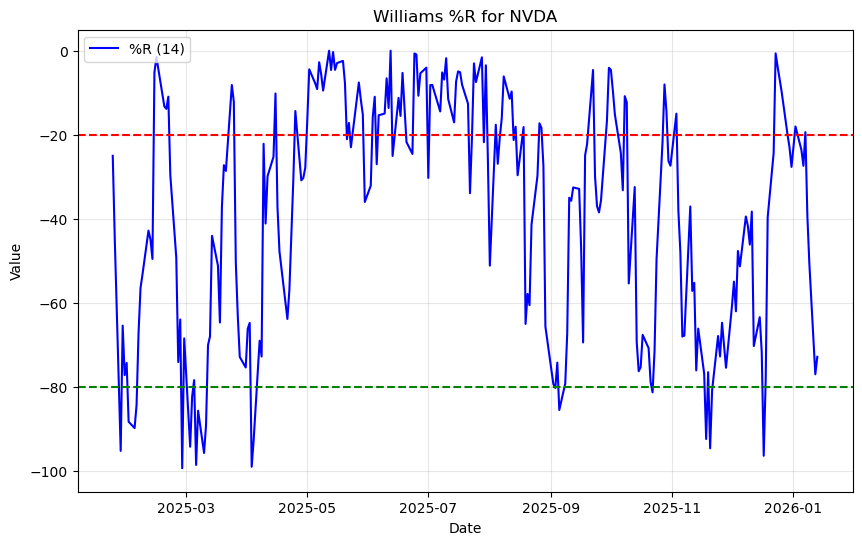

In [12]:
# Example (%R)

williams_r_period = 14
R = calculate_williams_r(df, williams_r_period)

plt.figure(figsize=(10, 6))
plt.plot(df.index, R, label=f'%R ({williams_r_period})', color='blue', linewidth=1.5)
plt.ylim(-105, 5)
plt.ylabel('Value')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.axhline(-20, color='red', linestyle='--', label='Overbought (-20)')
plt.axhline(-80, color='green', linestyle='--', label='Oversold (-80)')

plt.title(f'Williams %R for {ticker}')
plt.show()

In [13]:
# Rate of Change (ROC)
# ROC = (Close - Close_n) / Close_n * 100, where Close_n is the closing price n periods ago.

def calculate_roc(df: pd.DataFrame, period: int = 12, column: str = 'Close') -> pd.Series:
    """    
    Parameters:
    - df: DataFrame with price data.
    - period: window size (default 12).
    - column: yf data column to use (default 'Close').
    
    Returns:
    - Series with ROC values.
    
    Interpretation: positive = momentum up; cross zero signals changes.
    """
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not in DataFrame.")
    if len(df) < period + 1:
        raise ValueError(f"DataFrame must have at least {period + 1} rows.")
    
    return ((df[column] - df[column].shift(period)) / df[column].shift(period)) * 100 


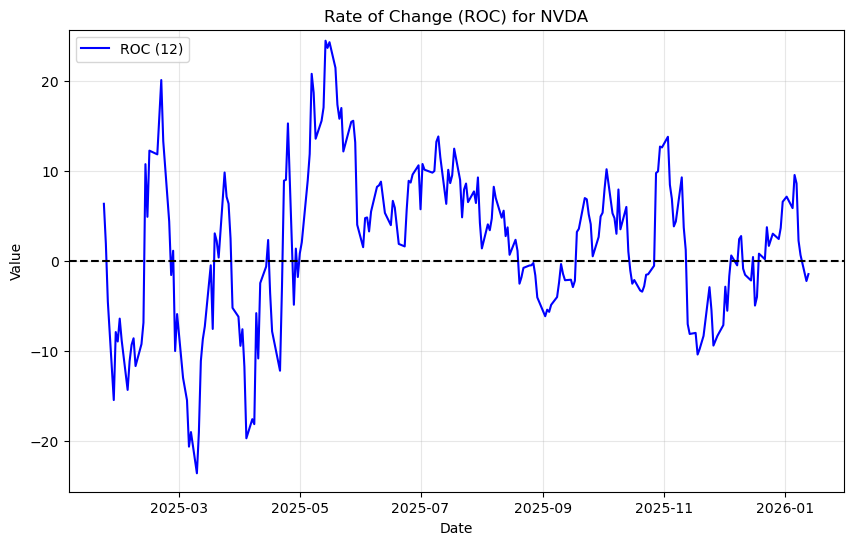

In [14]:
# Example (ROC)

roc_period = 12
ROC = calculate_roc(df, roc_period)

plt.figure(figsize=(10, 6))
plt.plot(df.index, ROC, label=f'ROC ({roc_period})', color='blue', linewidth=1.5)
max_roc_val = np.abs(ROC.dropna().values).max()
plt.ylim(-max_roc_val * 1.05, max_roc_val * 1.05)
plt.ylabel('Value')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.axhline(0, color='black', linestyle='--', label='Zero line')

plt.title(f'Rate of Change (ROC) for {ticker}')
plt.show()

In [15]:
# Ultimate Oscillator
# Buying Pressure (BP) = Close - Min(Low, Prior Close).
# True Range (TR) = Max(High, Prior Close) - Min(Low, Prior Close).
# The Ultimate Oscillator then uses these figures over three time periods:
    # Average7 = (7 Period BP Sum) / (7 Period TR Sum);
    # Average14 = (14 Period BP Sum) / (14 Period TR Sum);
    # Average28 = (28 Period BP Sum) / (28 Period TR Sum).
# UO = 100 x [(4 x Average7) + (2 x Average14) + Average28] / (4+2+1).

def calculate_ultimate_oscillator(df: pd.DataFrame, periods: list = [7, 14, 28], weights: list = [4,2,1]) -> pd.Series:
    """    
    Parameters:
    - df: DataFrame with 'High', 'Low', 'Close'.
    - periods: list of three periods (default [7, 14, 28]).
    - weights: list of weights for each period (default [4, 2, 1]).
    
    Returns:
    - Series with UO values (0-100).
    
    Interpretation: >70 overbought; <30 oversold. Reduces false signals.
    """
    required_cols = ['High', 'Low', 'Close']
    if not all(col in df.columns for col in required_cols):
        raise ValueError("DataFrame missing required columns.")
    max_period = max(periods)
    if len(df) < max_period + 1:
        raise ValueError(f"DataFrame must have at least {max_period + 1} rows.")
       
    bp = df['Close'] - np.minimum(df['Low'], df['Close'].shift(1)) 
    tr = np.maximum(df['High'], df['Close'].shift(1)) - np.minimum(df['Low'], df['Close'].shift(1)) 

    # Calculate Averages (Buying Pressure Sum / True Range Sum) for each period
    avg_bp_tr = []
    for period in periods:
        sum_bp = bp.rolling(period).sum()
        sum_tr = tr.rolling(period).sum()
        avg = sum_bp / sum_tr.replace(0, 0.0001) # avoid division by zero 
        avg_bp_tr.append(avg)
    
    # Calculate the weighted average
    total_weight = sum(weights)
    weighted_sum = sum(avg_bp_tr[i] * weights[i] for i in range(len(periods)))
    uo = 100 * weighted_sum / total_weight
    
    return uo


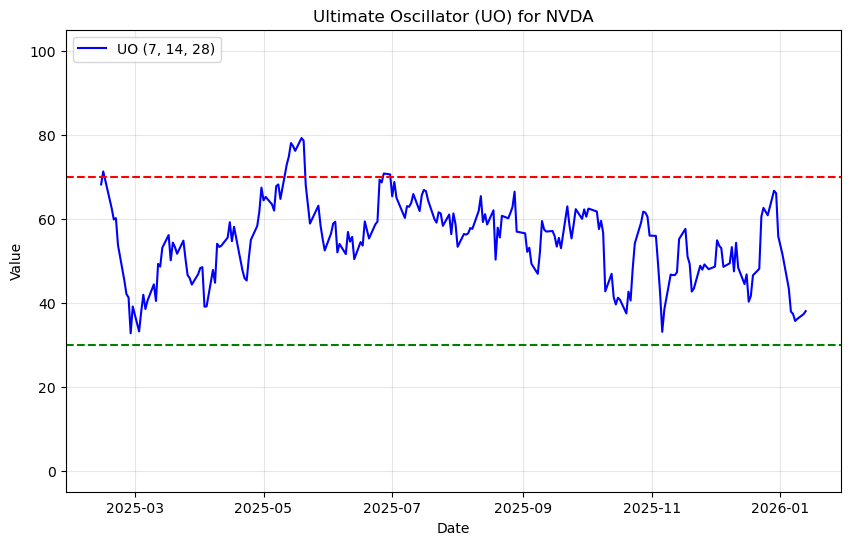

In [16]:
# Example (UO)

uo_periods = [7, 14, 28]
uo_weights = [4,2,1]
UO = calculate_ultimate_oscillator(df, uo_periods, uo_weights)

plt.figure(figsize=(10, 6))
plt.plot(df.index, UO, label=f'UO ({", ".join(map(str, uo_periods))})', color='blue', linewidth=1.5)
plt.ylim(-5, 105)
plt.ylabel('Value')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')

plt.title(f'Ultimate Oscillator (UO) for {ticker}')
plt.show()

In [17]:
# Money Flow Index (MFI) - volume/momentum indicator
# Raw Money Flow (RMF) = Typical Price x Volume.
# Money Flow Ratio (MFR) = (14 Period Positive Money Flow) / (14 Period Negative Money Flow), where 
# Positive Money Flow = Sum(RMF of all days in the period where TP > previous TP),
# Negative Money Flow = Sum(RMF of all days in the period where TP < previous TP).
# MFI = 100 - 100/(1 + Money Flow Ratio).

def calculate_mfi(df: pd.DataFrame, period: int = 14) -> pd.Series:
    """    
    Parameters:
    - df: DataFrame with 'High', 'Low', 'Close', 'Volume'.
    - period: window size (default 14).
    
    Returns:
    - Series with MFI values (0-100).
    
    Interpretation: >80 overbought; <20 oversold. Volume-weighted RSI.
    """
    required_cols = ['High', 'Low', 'Close', 'Volume']
    if not all(col in df.columns for col in required_cols):
        raise ValueError("DataFrame missing required columns.")
    if len(df) < period + 1:
        raise ValueError(f"DataFrame must have at least {period + 1} rows.")
    
    tp = (df['High'] + df['Low'] + df['Close']) / 3
    mf = tp * df['Volume']
    tp_diff = tp.diff()
    pos_mf = mf.where(tp_diff > 0, 0).rolling(window=period).sum()
    neg_mf = mf.where(tp_diff < 0, 0).rolling(window=period).sum()
    mfr = pos_mf / neg_mf
    mfi = 100 - (100 / (1 + mfr))
    
    return mfi


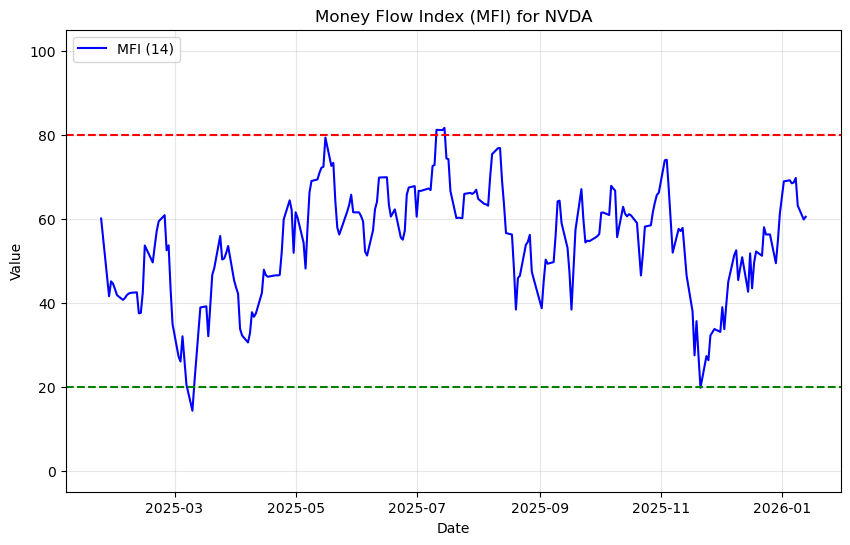

In [18]:
# Example (MFI)

mfi_period = 14
MFI = calculate_mfi(df, mfi_period)

plt.figure(figsize=(10, 6))
plt.plot(df.index, MFI, label=f'MFI ({mfi_period})', color='blue', linewidth=1.5)
plt.ylim(-5,105)
plt.ylabel('Value')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.axhline(80, color='red', linestyle='--', label='Overbought (80)')
plt.axhline(20, color='green', linestyle='--', label='Oversold (20)')

plt.title(f'Money Flow Index (MFI) for {ticker}')
plt.show()